# reference trajectory

In [1]:

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1' # Use GPU 1
import pickle
import matplotlib.pyplot as plt

import hydra
from hydra import initialize, compose
from hydra.core.hydra_config import HydraConfig
from hydra.core.global_hydra import GlobalHydra
from omegaconf import DictConfig, OmegaConf

from pathlib import Path
from utils.utils import *
'''
OmegaConf.register_new_resolver('eq', lambda x, y: x.lower()==y.lower())
OmegaConf.register_new_resolver('contains', lambda x, y: x.lower() in y.lower())
OmegaConf.register_new_resolver('if_multi', lambda pred, a, b: a if pred.name=='MULTIRUN' else b)
OmegaConf.register_new_resolver('resolve_default', lambda default, arg: default if arg=='' else arg)
'''

"\nOmegaConf.register_new_resolver('eq', lambda x, y: x.lower()==y.lower())\nOmegaConf.register_new_resolver('contains', lambda x, y: x.lower() in y.lower())\nOmegaConf.register_new_resolver('if_multi', lambda pred, a, b: a if pred.name=='MULTIRUN' else b)\nOmegaConf.register_new_resolver('resolve_default', lambda default, arg: default if arg=='' else arg)\n"

In [ ]:
dataset = "multiclip"
cpath = "glados"
run_id = "0"
with initialize(version_base=None, config_path="configs"):
    cfg_temp = compose(config_name='config.yaml', overrides=[f"dataset=fly_{dataset}", f"train=train_fly_{dataset}", f"paths={cpath}"], return_hydra_config=True)
    HydraConfig.instance().set_config(cfg_temp)
    cfg = OmegaConf.to_container(cfg_temp, resolve=True)
    cfg = OmegaConf.create(cfg)
    
print(cfg.train)
print(cfg.paths.base_dir)


{'name': 'train_fly_multiclip', 'version': 'debug', 'gpu': '1', 'wandb_project': 'eabe_debug', 'env_name': 'fly_freejnt_multiclip', 'algo_name': 'ppo', 'task_name': 'fly_multiclip', 'note': None, 'num_envs': 1, 'num_timesteps': 10000000000, 'eval_every': 200000000, 'num_resets_per_eval': 1, 'reward_scaling': 1, 'episode_length': 1001, 'normalize_observations': True, 'action_repeat': 1, 'clipping_epsilon': 0.2, 'unroll_length': 20, 'num_minibatches': 32, 'num_updates_per_batch': 8, 'discounting': 0.95, 'learning_rate': 2e-05, 'kl_weight': 0.005, 'entropy_cost': 0.01, 'batch_size': 1, 'seed': 0, 'encoder_hidden_layer_sizes': [256, 256], 'decoder_hidden_layer_sizes': [256, 256], 'value_hidden_layer_sizes': [256, 256], 'restore_checkpoint': False, 'freeze_encoder': False, 'state_metric_list': ['pos_reward', 'quat_reward', 'joint_reward', 'angvel_reward', 'bodypos_reward', 'endeff_reward', 'reward_ctrlcost', 'too_far', 'bad_pose', 'bad_quat', 'termination', 'fall'], 'info_metric_list': ['cu

In [3]:
for k in cfg.paths.keys():
    if (k != 'user'):
        cfg.paths[k] = Path(cfg.paths[k])
        cfg.paths[k].mkdir(parents=True, exist_ok=True)

env_cfg = cfg.dataset
env_args = cfg.dataset.env_args
print(cfg.train.env_name)

fly_freejnt_multiclip


In [4]:
cfg.paths.base_dir = cfg.paths.base_dir.parent / 'ckpt'
reference_path = cfg.paths.data_dir/ f"clips/all_clips_batch_interp.p"
# reference_path = cfg.paths.data_dir/ f"clips/{cfg.dataset['clip_idx']}"
reference_path.parent.mkdir(parents=True, exist_ok=True)

with open(reference_path, "rb") as file:
    # Use pickle.load() to load the data from the file
    reference_clip = pickle.load(file)


dict_keys(['position', 'quaternion', 'joints', 'body_positions', 'velocity', 'joints_velocity', 'angular_velocity', 'body_quaternions'])


Text(0.5, 0, 'Timestep')

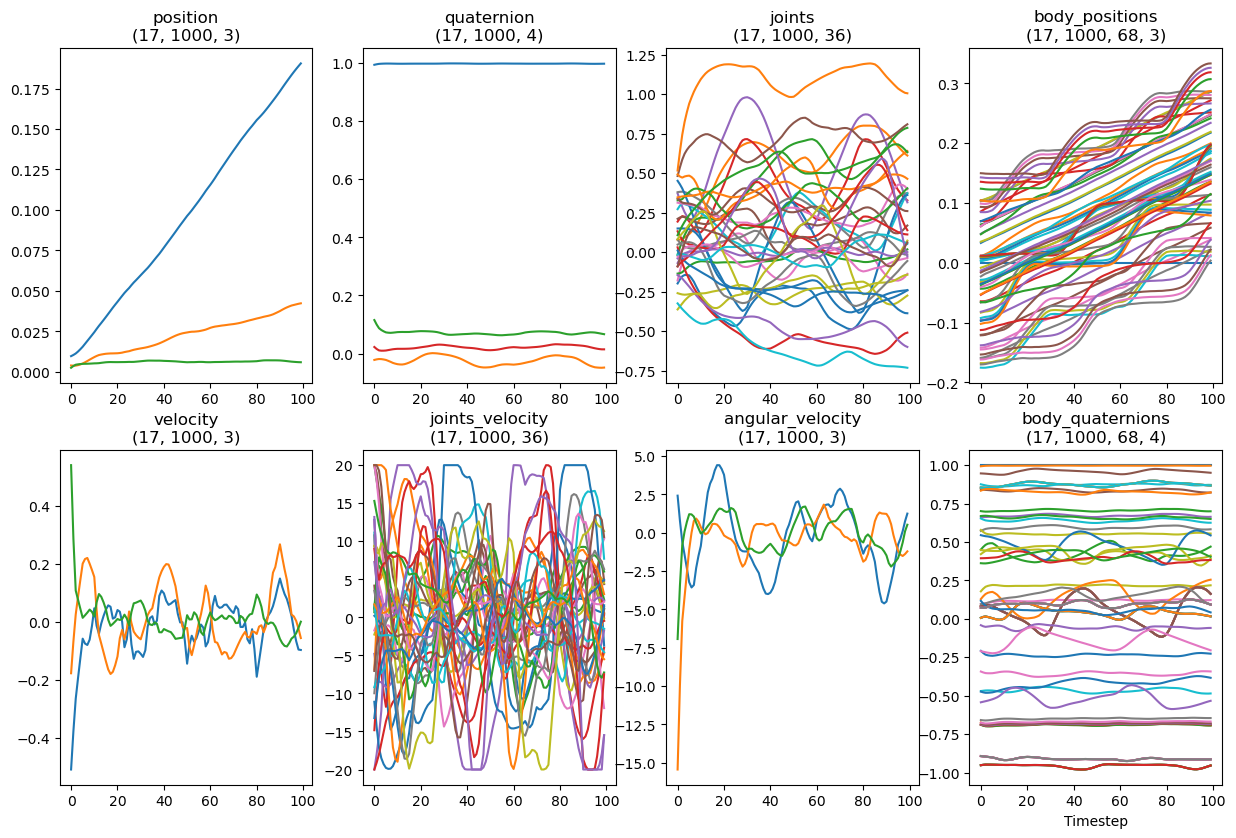

In [5]:
print(reference_clip.__dict__.keys())
ctr=0
plt.figure(figsize=(15,20))
for keys in reference_clip.__dict__.keys():
    x=reference_clip.__dict__[keys]
    ax = plt.subplot(4,4,ctr+1)
    if (len(x.shape) == 3):
        plt.plot(x[0,:100])
    else:
        plt.plot(x[0,:100,:,0])
    #for kk in range(x.shape[0]):
    #    plt.plot(x[kk,:100,0])
    ax.set_title(keys + "\n" + str(x.shape))
    ctr+=1
ax.set_xlabel("Timestep")

## Environment

In [6]:
from envs.Fly_Env_Brax import FlyTracking, FlyMultiClipTracking, FlyRunSim, _bounded_quat_dist
#clipn = np.random.choice(reference_clip.position.shape[0])

from brax import envs
envs.register_environment("fly_freejnt_clip", FlyTracking)
envs.register_environment("fly_freejnt_multiclip", FlyMultiClipTracking)
envs.register_environment("fly_run_policy", FlyRunSim)
# cfg.dataset.env_args.mjcf_path = '/home/eabe/Research/MyRepos/Brax-Rodent-Track/assets/fruitfly/fruitfly_viz_only.xml'
print(cfg.train.env_name)
env = envs.get_environment(
    cfg.train.env_name,
    reference_clip=reference_clip,
    **cfg.dataset.env_args, # all other env args
)
print(env)

fly_freejnt_multiclip
Loaded Model: /home/hg84/Documents/Github/Brax-Tracking//assets/fruitfly/fruitfly_force_fast.xml
self._steps_for_cur_frame: 1.0


In [7]:
cfg.dataset.env_args.body_names
cp = cfg.dataset.env_args.mjcf_path
cp

'/home/hg84/Documents/Github/Brax-Tracking//assets/fruitfly/fruitfly_force_fast.xml'

In [8]:
env._reference_clips

ReferenceClip(position=Array([[[9.63562727e-03, 3.85576859e-03, 2.44636135e-03],
        [1.03711253e-02, 3.74924461e-03, 3.52982385e-03],
        [1.12697538e-02, 3.77594447e-03, 4.33021970e-03],
        ...,
        [2.03552961e+00, 2.91652441e-01, 6.25398103e-03],
        [2.03781557e+00, 2.90505886e-01, 5.56383282e-03],
        [2.04030132e+00, 2.88686126e-01, 4.49898234e-03]],

       [[7.47851748e-03, 1.18191144e-03, 4.72897431e-03],
        [9.83935874e-03, 2.07634247e-03, 5.08452440e-03],
        [1.21317068e-02, 3.04533564e-03, 5.35295857e-03],
        ...,
        [2.06211400e+00, 5.46392575e-02, 4.55000252e-03],
        [2.06489539e+00, 5.43532372e-02, 4.47211973e-03],
        [2.06742287e+00, 5.46060428e-02, 5.13108820e-03]],

       [[5.68831619e-03, 2.50418205e-03, 5.28165326e-03],
        [6.73002843e-03, 2.74921278e-03, 5.28800627e-03],
        [7.77174113e-03, 2.99424352e-03, 5.29435882e-03],
        ...,
        [1.50246227e+00, 2.52063036e-01, 6.69905962e-03],
      

In [9]:
'''
cfg.dataset.env_args.torque_actuators = False
cfg.dataset.env_args.mjcf_path = None
#cfg.dataset.env_args.mjcf_path
'''

'\ncfg.dataset.env_args.torque_actuators = False\ncfg.dataset.env_args.mjcf_path = None\n#cfg.dataset.env_args.mjcf_path\n'

In [10]:
'''
env = envs.get_environment(
    cfg.train.env_name,
    reference_clip=reference_clip,
    **cfg.dataset.env_args, # all other env args
)
print(env)
'''

'\nenv = envs.get_environment(\n    cfg.train.env_name,\n    reference_clip=reference_clip,\n    **cfg.dataset.env_args, # all other env args\n)\nprint(env)\n'

In [11]:
import functools
import jax
import mujoco
import jax.numpy as jp
from custom_brax import custom_wrappers
from utils.fly_logging import log_eval_rollout

In [12]:
rollout_env = custom_wrappers.AutoResetWrapperTracking(env)
    
# rollout_env = custom_wrappers.RenderRolloutWrapperTracking(env)
# define the jit reset/step functions
jit_reset = jax.jit(rollout_env.reset)
jit_step = jax.jit(rollout_env.step)
state = jit_reset(jax.random.PRNGKey(0))

/home/hg84/Documents/Github/Brax-Tracking/envs/Fly_Env_Brax.py:205: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  reference_frame = jax.tree_map(
/home/hg84/Documents/Github/Brax-Tracking/envs/Fly_Env_Brax.py:549: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  return jax.tree_map(lambda x: x[info["clip_idx"]], self._reference_clips)
/home/hg84/miniconda3/envs/stac-mjx-env/lib/python3.11/site-packages/jax/_src/linear_util.py:193: DeprecationWarning: Passing arguments 'a', 'a_min' or 'a_max' to jax.numpy.clip is deprecated. Please use 'arr', 'min' or 'max' respectively instead.
  ans = self.f(*args, **dict(self.params, **kwargs))
/home/hg84/Documents/Github/Brax-Tracking/envs/Fly_Env_Brax.py:549: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any 

In [13]:
state2 = jit_step(state, jax.random.randint(jax.random.PRNGKey(0), (36,), 0, 1000)*.001)

/home/hg84/Documents/Github/Brax-Tracking/envs/Fly_Env_Brax.py:271: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  reference_clip = jax.tree_map(
/home/hg84/Documents/Github/Brax-Tracking/envs/Fly_Env_Brax.py:549: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  return jax.tree_map(lambda x: x[info["clip_idx"]], self._reference_clips)
/home/hg84/Documents/Github/Brax-Tracking/envs/Fly_Env_Brax.py:549: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  return jax.tree_map(lambda x: x[info["clip_idx"]], self._reference_clips)


/home/hg84/Documents/Github/Brax-Tracking/envs/Fly_Env_Brax.py:271: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  reference_clip = jax.tree_map(
/home/hg84/Documents/Github/Brax-Tracking/envs/Fly_Env_Brax.py:549: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  return jax.tree_map(lambda x: x[info["clip_idx"]], self._reference_clips)
/home/hg84/Documents/Github/Brax-Tracking/envs/Fly_Env_Brax.py:549: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  return jax.tree_map(lambda x: x[info["clip_idx"]], self._reference_clips)


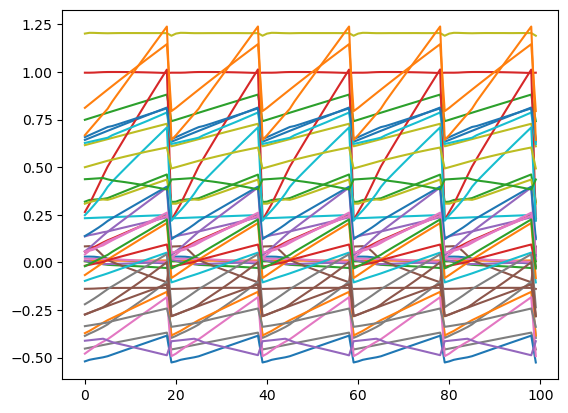

In [14]:
qpos = state.pipeline_state.qpos
nT = 100
qq = jp.zeros((nT, qpos.shape[0]))
for jj in range(nT):
    state = jit_step(state, jax.random.randint(jax.random.PRNGKey(0), (36,), 0, 100)*.001)
    qq = qq.at[jj].set(state.pipeline_state.qpos)

plt.plot(qq)

## test inference

In [15]:
from custom_brax import custom_ppo as ppo
from custom_brax import custom_wrappers
from custom_brax import custom_ppo_networks

from orbax import checkpoint as ocp
from flax.training import orbax_utils
import optax

/home/hg84/miniconda3/envs/stac-mjx-env/lib/python3.11/site-packages/brax/v1/jumpy.py:34: DeprecationWarning: brax.v1 is deprecated and will be removed in a future release.
  warnings.warn(
/home/hg84/miniconda3/envs/stac-mjx-env/lib/python3.11/site-packages/brax/v1/__init__.py:26: DeprecationWarning: brax.v1 is deprecated and will be removed in a future release.
  warnings.warn(


In [16]:
rollout_data = {'clip{:02d}'.format(n): {} for n in range(env._n_clips)}
# for n in range(env._n_clips):
n = 0
# reset_rng, act_rng = jax.random.split(policy_params_fn_key)
rng = jax.random.PRNGKey(0)
reset_rng, act_rng = jax.random.split(rng)
state = jit_reset(reset_rng)
state.info['clip_idx'] = n
print(state.info['clip_idx'])

rollout = [state]
# rollout_len = env_args["clip_length"]*int(rollout_env._steps_for_cur_frame)
rollout_len = env._clip_length
ctrl_all = []
for i in range(rollout_len):
    _, act_rng = jax.random.split(act_rng)
    obs = state.obs
    ctrl, extras = jit_inference_fn(obs, act_rng)
    state = jit_step(state, ctrl)
    ctrl_all.append(ctrl.copy())
    rollout.append(state)
rollout2 = [state.pipeline_state for state in rollout]
rollout_data['clip{:02d}'.format(n)]['qposes'] = jp.stack([state.qpos for state in rollout2])
rollout_data['clip{:02d}'.format(n)]['qvels'] = jp.stack([state.qvel for state in rollout2])
rollout_data['clip{:02d}'.format(n)]['ctrl'] = jp.stack(ctrl_all)
# rollout_data['clip{:02d}'.format(n)]['sensordata'] = jp.stack([state.sensordata for state in rollout2])


0


NameError: name 'jit_inference_fn' is not defined

In [43]:
cfg.paths.ckpt_dir/f"{run_id}"

PosixPath('/data/users/hg84/biomech_model/Flybody/RL_Flybody/debug/ckpt/0')

In [44]:
net = functools.partial(
                custom_ppo_networks.make_intention_ppo_networks,
                encoder_hidden_layer_sizes=cfg.train['encoder_hidden_layer_sizes'],
                decoder_hidden_layer_sizes=cfg.train['decoder_hidden_layer_sizes'],
                value_hidden_layer_sizes=cfg.train['value_hidden_layer_sizes'])

In [23]:
from custom_brax.intention_network import IntentionNetwork, make_intention_policy
net = IntentionNetwork( encoder_layers=cfg.train['encoder_hidden_layer_sizes'],
                       decoder_layers=cfg.train['decoder_hidden_layer_sizes'],
                       reference_obs_size=env.observation_size,)

/home/hg84/Documents/Github/Brax-Tracking/envs/Fly_Env_Brax.py:205: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  reference_frame = jax.tree_map(
/home/hg84/Documents/Github/Brax-Tracking/envs/Fly_Env_Brax.py:549: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  return jax.tree_map(lambda x: x[info["clip_idx"]], self._reference_clips)
/home/hg84/Documents/Github/Brax-Tracking/envs/Fly_Env_Brax.py:549: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  return jax.tree_map(lambda x: x[info["clip_idx"]], self._reference_clips)


In [18]:
net

IntentionNetwork(
    # attributes
    encoder_layers = [256, 256]
    decoder_layers = [256, 256]
    reference_obs_size = 1020
    latents = 60
)